## Outline  
1) Define basic units (points, lines, shapes)  
2) Define distance calculator  
3) Inversion calculator in 2D, 3D   
4) Plotting/visualizations  

- We define points as lists of coordinates, such as [0,0,0] for the origin in 3D  
- Lines and other shapes are also defined as lists of points rather than unique objects  
- This approach is a flexible but lazy way to do inversion 
    - Flexible because inverting any shape is equally complex
    - Lazy because we don't calculate any closed-form equation of the inverse, which is certainly possible in some cases

In [21]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from trianglesolver import solve, degree, ssa, sas
from mpl_toolkits.mplot3d import axes3d

from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
%matplotlib inline
from IPython.display import display

In [2]:
def calc_distance(p1, p2):
    """
    Calculate Euclidean distance between any two points for any number of dimensions
    Input points as lists with coordinates as elements like [x,y,z...]
    """
    dist_by_dim = [(p1[i] - p2[i]) for i in range(len(p1))]
    squared_terms = [dim_dist**2 for dim_dist in dist_by_dim]
    total_dist = np.sqrt(sum(squared_terms))
    return total_dist

In [3]:
def calc_inverse_dist(point, radius=1):
    """
    Calculate the distance for the inverse point from a circle inversion of given radius
    """
    original_distance = calc_distance([0, 0], point)
    inverse_distance = (radius**2) / original_distance
    return inverse_distance


# Check that distance of anywhere on the unit circle is 1
# print(calc_distance([0, 0], [x[33], y[33]]))

In [4]:
def calc_slope(point):
    """
    Calculate the slope of the line from a point and the origin in 2D
    """
    if point[0] != 0:
        return point[1] / point[0]
    else:
        # What slope to return when x-change is 0?
        # return np.inf * np.sign(point[1])
        # Let's just return a big value, but don't round off later
        # I would rather have some numerical error in just this case than
        # an rounding/truncating error term in every case
        return 99999999 * np.sign(point[1])

In [5]:
def line_solve(a=None, b=None, c=None, A=None, B=None, C=None):
    """
    When a side is 0, we are just dealing with a vertical/horizontal line calculation
    If one side is 0, the other sides are equal and all angles are 0
    """
    a = 0 if A == 0 else a
    b = 0 if B == 0 else b
    c = 0 if C == 0 else c
    if a == 0:
        b = b if b is not None else c
        c = c if c is not None else b
    elif b == 0:
        a = a if a is not None else c
        c = c if c is not None else a
    elif c == 0:
        a = a if a is not None else b
        b = b if b is not None else a
    return a, b, c, 0, 0, 0

In [6]:
def solve_all(a=None, b=None, c=None, A=None, B=None, C=None):
    """
    Lowercase letters represent sides, Uppercase letters are angle values for opposite sides
    """
    # If all sides and angles provided are positive
    if all(s > 0 for s in (a, b, c) if s is not None) and all(a != 0 for a in (A,B,C) if a is not None):
        # print('all positive')
        # Just use pre-built solve function
        a, b, c, A, B, C = solve(a, b, c, A, B, C)

    # If just one side is 0 or any angle is 0
    elif (sum(s == 0 for s in (a,b,c) if s is not None) == 1) or any(a == 0 for a in (A,B,C) if a is not None):
        # print('exactly one zero')
        # Use our function for the calculation
        a, b, c, A, B, C = line_solve(a, b, c, A, B, C)

    # If at least one side is negative
    elif sum(s < 0 for s in (a, b, c) if s is not None) < 3:
        # print('some negative')
        # Process the input and output to work with pre-built solve
        # Not done yet
        a, b, c, A, B, C = solve(a, b, c, A, B, C)
    else:
        raise ArithmeticError('Does not compute for provided input values')
    return a, b, c, A, B, C

In [7]:
def calc_point_inverse(original_point):
    """
    Do a 2D circle inversion of a set of coordinates on the unit circle:
    - Calculate the distance from that point to the origin of the circle
    - Find the slope of the line which the point and the origin lie on
    - Find the angle between that line and the x-axis
    - Use inverse hypotenuse length and angle to get coordinates of inverse point
    """
    original_point = deepcopy(original_point)
    x_sign = True if original_point[0] >= 0 else False
    y_sign = True if original_point[1] >= 0 else False
    original_point[0] = abs(original_point[0])
    original_point[1] = abs(original_point[1])
    point_slope = calc_slope(original_point)
    a, b, c, A, B, C = solve_all(a=1, b=point_slope, C=(math.pi/2))
    theta = deepcopy(B)
    inverse_distance = calc_inverse_dist(original_point)
    a, b, c, A, B, C = solve_all(c=inverse_distance, B=theta, C=(math.pi/2))
    x_inverse = a if x_sign else -a
    y_inverse = b if y_sign else -b
    inverse_point = [x_inverse, y_inverse]
    return inverse_point

In [8]:
def circle_invert(geo_object):
    """
    Run point inverse on all points in the object
    Object is just a list of points (which are themselves lists of coordinates)
    """
    inverse = []
    for point in geo_object:
        inverse.append(calc_point_inverse(point))
    return inverse

In [9]:
def make_line(coordinate, line_type, density=10000, limits=1000, others=[0,0,0,0]):
    """
    Return points for a vertical or horizontal line at the given x or y coordinate
    For instance, input (1, 'vert', 10000, 1000) 
    to get 10000 values for a vertical line at x=1 from -1000 to +1000
    For linear, 'others' includes the (slope) m and (y intercept) b
    For parabola, 'others' includes the x scale, y scale, x shift, and y shift
    """
    if line_type=="hor":
        xline = np.linspace(-limits, limits, density)
        yline = np.linspace(coordinate, coordinate, density)
    elif line_type=="vert":
        xline = np.linspace(coordinate, coordinate, density)
        yline = np.linspace(-limits, limits, density)
    elif line_type=="linear":
        xline = np.linspace(-limits, limits, density)
        yline = [((val*others[0])+others[1]) for val in xline]
    elif line_type=="parabola":
        xline = np.linspace(-limits, limits, density)
        yline = [(((((val*others[0])-others[2])**2)*others[1])+others[3]) for val in xline]
    line = [[xline[i], yline[i]] for i in range(density)]
    return line

In [10]:
def plot_inversion(original_obj, inverse_obj, inversion_bound, lim, dims='3d'):
    """
    Function for plotting an object, its inverse, and the bound of the inverse
    original_obj = list of coordinates on each of the axes for the object
    inverse_obj = list of coordinates on each of the axes for the object's inverse
    inverse_bound = list of coordinates for the inversion boundary. Depends on circle/sphere method for inversion
    lim = list of axis limits for the plot
    dims = number of dimensions for plotting ('2d' or '3d')
    """
    fig = plt.figure()
    if dims=='3d':
        ax = plt.axes(projection=dims)
    plt.plot(inversion_bound[0], inversion_bound[1])
    plt.plot(original_obj[0], original_obj[1])
    plt.plot(inverse_obj[0], inverse_obj[1])
    plt.xlim(lim[0][0], lim[0][1])
    plt.ylim(lim[1][0], lim[1][1])
    plt.legend(['Inversion Boundary', 'Original Object', 'Inverse Object'])
#     ax.set_aspect("equal")
    plt.show()
    return

In [11]:
# Calculate coordinates for unit circle
angles = np.linspace(0, 2, 100) # Angles in radians
pi = np.pi
unit_circ_x = []
unit_circ_y = []
for angle in angles:
    unit_circ_x.append(np.cos(angle * pi))
    unit_circ_y.append(np.sin(angle * pi))
unit_circle_coordinates = [unit_circ_x, unit_circ_y]

In [12]:
def total_inversion(original_object, inversion_boundary, limits, dims='3d'):
    """
    Condenses inversion steps further
    """
    inversion_results = circle_invert(original_object)
    inversion_x,inversion_y = zip(*inversion_results)
    original_x,original_y = [val[0] for val in original_object],[val[1] for val in original_object]
    plot_inversion(
        original_obj=[original_x, original_y],
        inverse_obj=[inversion_x, inversion_y],
        inversion_bound=[inversion_boundary[0], inversion_boundary[1]],
        lim=[limits[0], limits[1]],
        dims=dims
    )
    return [original_object, inversion_results, inversion_boundary]

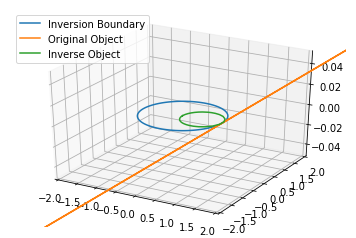

In [13]:
# Create a 2D vertical line at x=1 and invert
my_line = make_line(1, 'vert')
total_inversion(my_line, unit_circle_coordinates, [[-2,2], [-2,2]]);

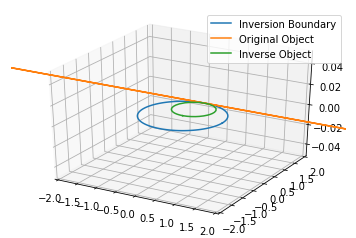

In [14]:
# Create a 2D horizontal line at y=1 and invert
my_line = make_line(1, 'hor')
total_inversion(my_line, unit_circle_coordinates, [[-2,2], [-2,2]]);

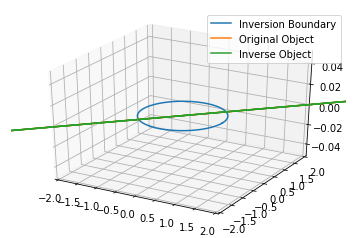

In [15]:
# Create a 2D horizontal line at x=y and invert
my_line = make_line(1, 'linear', others=[1,0])
total_inversion(my_line, unit_circle_coordinates, [[-2,2], [-2,2]]);

The original line and the inverse are equal for any line going through the origin. So it makes sense that the lines overlap in the plot above.

Create and invert parabolas at various shifts:  
- x^2 = y
- (x^2) + 1 = y
- (x-1)^2 = y
- (4x)^2 - 4 = y

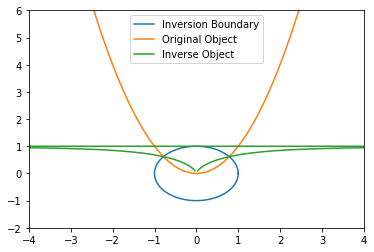

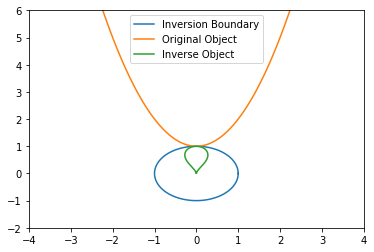

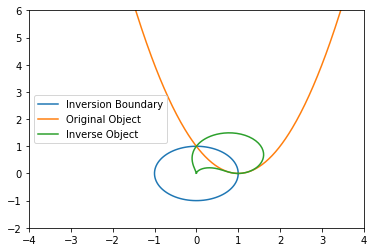

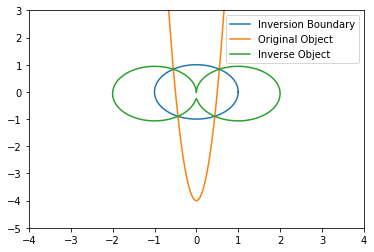

In [16]:
my_line = make_line(1, 'parabola', density=1000, limits=3, others=[1,1,0,0])
total_inversion(my_line, unit_circle_coordinates, [[-4,4], [-2,6]], dims='2d');

my_line = make_line(1, 'parabola', density=1000, limits=10, others=[1,1,0,1])
total_inversion(my_line, unit_circle_coordinates, [[-4,4], [-2,6]], dims='2d');

my_line = make_line(1, 'parabola', density=1000, limits=10, others=[1,1,1,0])
total_inversion(my_line, unit_circle_coordinates, [[-4,4], [-2,6]], dims='2d');

my_line = make_line(1, 'parabola', density=10000, limits=10, others=[4,1,0,-4])
total_inversion(my_line, unit_circle_coordinates, [[-4,4], [-5,3]], dims='2d');

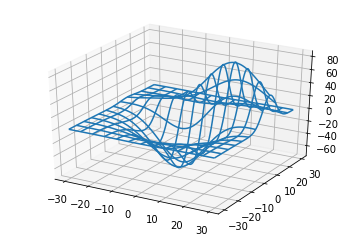

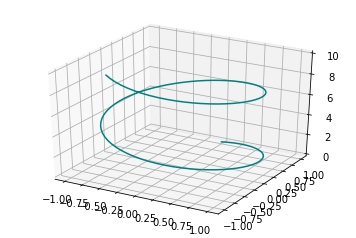

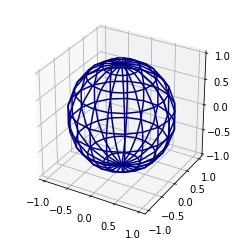

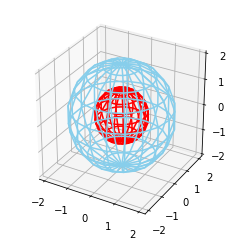

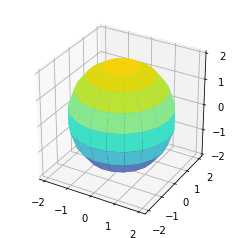

In [294]:
# Some cools plots in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

z_plane = deepcopy(X)
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
zline = np.linspace(0, 10, 100)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'teal')

z_plane = deepcopy(X)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_aspect("equal")
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="navy")

z_plane = deepcopy(X)
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
# zline = np.linspace(0, 10, 100)
# xline = np.sin(zline)*np.cos(zline)
# yline = np.sin(zline)*np.sin(zline)
# ax.plot3D(xline, yline, zline, 'teal')
ax.set_aspect("equal")
ax.plot_wireframe(x, y, z, color="red")
x = 2*np.cos(u)*np.sin(v)
y = 2*np.sin(u)*np.sin(v)
z = 2*np.cos(v)
ax.plot_wireframe(x, y, z, color="skyblue")

# A cool coloring functions
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(100, 50)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.viridis, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=True, shade=False)
ax.set_aspect("equal")
plt.show()

# 3D Inversion

How to do sphere inversion?
- Calculate the distance (d) from the origin
- Normalize the vector by dividing by this distance
- Calculate the inverse distance from the origin (1/d)
- Solve for the inverse point by multiplying the normalized vector by the inverse distance

In [215]:
def generalized_inversion(points):
    """
    A function which inverts a point in any number of dimensions by the unit-object (i.e. circle, sphere)
    Take a list of points, which are lists of coordinates
    Returns a list of inverse points
    """
    inverse_points = []
    for point in points:
        original_distance = np.sqrt(sum([i**2 for i in point]))
        normalized_point = [axis_val/original_distance for axis_val in point]
        inverse_distance = 1/original_distance
        inverse_point = [axis_val*inverse_distance for axis_val in normalized_point]
        inverse_points.append(inverse_point)
    return inverse_points

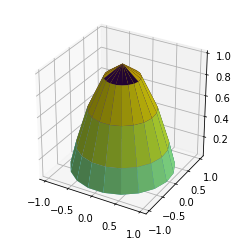

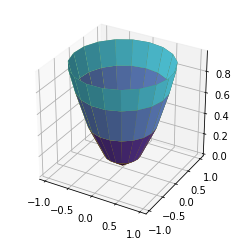

In [311]:
ax = plt.axes(projection='3d')
ax.set_aspect("equal")

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
original_x = np.sin(u)*np.sin(v)
original_y = np.cos(u)*np.sin(v)
original_z = np.cos(v)*np.cos(v)
surf = ax.plot_surface(original_x, original_y, original_z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=True, shade=True)
plt.show()

ax = plt.axes(projection='3d')
ax.set_aspect("equal")

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
original_x = np.sin(u)*np.sin(v)
original_y = np.cos(u)*np.sin(v)
original_z = np.sin(v)*np.sin(v) 
surf = ax.plot_surface(original_x, original_y, original_z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=True, shade=True)

In [518]:
original_x = np.linspace(-50, 50, 1000)
original_y = [np.cos(p) for p in original_x] 
original_z = [np.cos(p) for p in original_x]
original_points = [[x,y,z] for x,y,z in zip(original_x,original_y,original_z)]

In [519]:
inverse_result = generalized_inversion(original_points)
inverse_x = [point[0] for point in inverse_result]
inverse_y = [point[1] for point in inverse_result]
inverse_z = [point[2] for point in inverse_result]

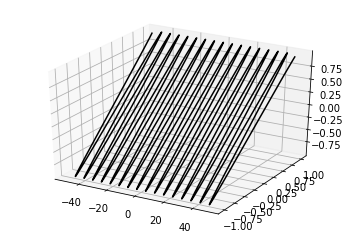

In [520]:
ax = plt.axes(projection='3d')
ax.plot3D(original_x, original_y, original_z, 'black');
plt.show()

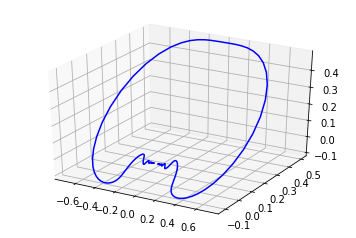

In [521]:
ax = plt.axes(projection='3d')
ax.plot3D(inverse_x, inverse_y, inverse_z, 'blue');
plt.show()